<h1 style="color: DeepSkyBlue; text-align: center;">Assurance - Cross Selling</h1>

<h5 style="color: DeepSkyBlue; text-align: left;">Prepared By : Ibrahim Kerdi</h5>

**The workflow includes:**  

1. Importing relevant libraries  
2. Reading and inspecting the data  
3. Basic Exploratory Data Analysis (EDA)) and plots  
4. Feature preparation  
5. Model training (XGBoost) with hyperparameter tuning  
6. Generating predictions

**OBJECTIVE:**
This dataset is about an Insurance company that has provided Health Insurance to its customers. Now we need build a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.



**1. Import Libraries**


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier


In [2]:
# Display settings
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)



**2. Load Data**


In [3]:
train_df = pd.read_csv("./DataBase/train.csv")
test_df = pd.read_csv("./DataBAse/test.csv")
train_df.head()


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [32]:
missing_values = train_df.isna().sum()  
print(missing_values)

missing_values_test = train_df.isna().sum()
print(missing_values_test)

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64



**3. Quick Inspection and Feature Declarations**


Check for missing values, data types, distribution, etc.


In [4]:
print("Data Shape: ",train_df.shape,"\n")
print(train_df.info(),"\n")
print("NULL VALUES COUNT: \n",train_df.isnull().sum())

Data Shape:  (11504798, 12) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB
None 

NULL VALUES COUNT: 
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage        

**Features Explanations**:

1. `id`: A unique identifier for each customer or observation in the dataset. It has no predictive value but helps differentiate records.
2. `gender`: The gender of the customer
3. `age`: The age of the customer.
4. `region_code`: A categorical/encoded value representing the customer's geographic location or residence region.
5. `policy_sales_channel`: The channel through which the insurance policy was sold.
6. `annual_premium`: The premium amount that the customer is required to pay annually for the insurance policy.
7. `vintage`: The number of days since the customer signed up with the insurance company.
8. `driving_license`: Indicates whether the customer holds a valid driving license.
9. `previously_insured`: Indicates if the customer has had prior insurance coverage.
10. `vehicle_age`: The age of the vehicle being insured.
11. `vehicle_damage`: Indicates if the vehicle has been involved in past damage-related incidents.
12. `response`:The target variable indicating whether the customer responded positively to purchasing or being interested in insurance.

Checking For Duplicates 

In [5]:
print("Train Data Duplicates Count:",train_df.duplicated().sum())
print("Test  Data  Duplicates Count:",test_df.duplicated().sum())

Train Data Duplicates Count: 0
Test  Data  Duplicates Count: 0


Duplicates should be identified and removed to ensure data accuracy and integrity , not our Case .

Checking if training data is Imbalanced

<Figure size 600x600 with 0 Axes>

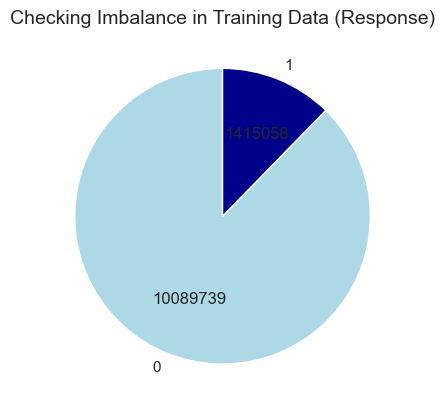

In [6]:
response_data = train_df['Response'].value_counts()  
plt.figure(figsize=(6, 6))  
fig, ax = plt.subplots()  
ax.pie(  
    response_data,   
    labels=response_data.index,   
    autopct=lambda p: f'{int(p * sum(response_data) / 100)}',
    startangle=90, 
    colors=['lightblue', 'darkblue']
)  
ax.set_title('Checking Imbalance in Training Data (Response)', fontsize=14)  
plt.show()  

The dataset exhibits significant imbalance between "Response" and "No Response." Due to the large dataset size, downsampling is advisable to address this, as our new campaign requires minimizing false positives to optimize budget and support the marketing team's efforts.

In [7]:
df_downsampled = train_df.copy()  

In [8]:
majority_class = train_df[train_df['Response'] == 0]  
minority_class = train_df[train_df['Response'] == 1]  


majority_downsampled = majority_class.sample(n=len(minority_class), random_state=42)  
df_downsampled = pd.concat([majority_downsampled, minority_class])  
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
df_downsampled.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1196128,Female,44,1,28.0,0,1-2 Year,Yes,56986.0,26.0,11,1
1,6654021,Male,60,1,33.0,1,1-2 Year,No,2630.0,152.0,275,0
2,4983478,Female,46,1,28.0,0,1-2 Year,Yes,46509.0,156.0,249,0
3,3300373,Female,24,1,41.0,1,< 1 Year,No,28292.0,152.0,191,0
4,11310953,Female,38,1,20.0,0,1-2 Year,Yes,2630.0,26.0,272,0


**Basic EDA & Plotting**


Distribution of Age

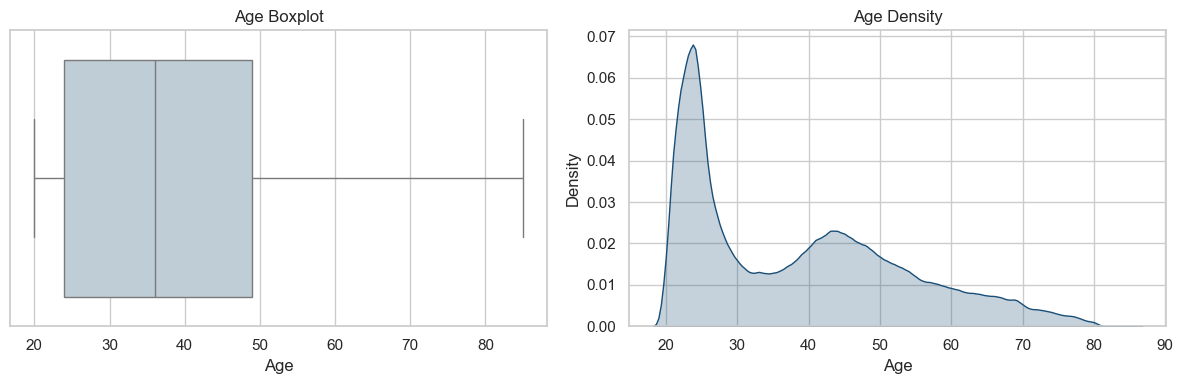

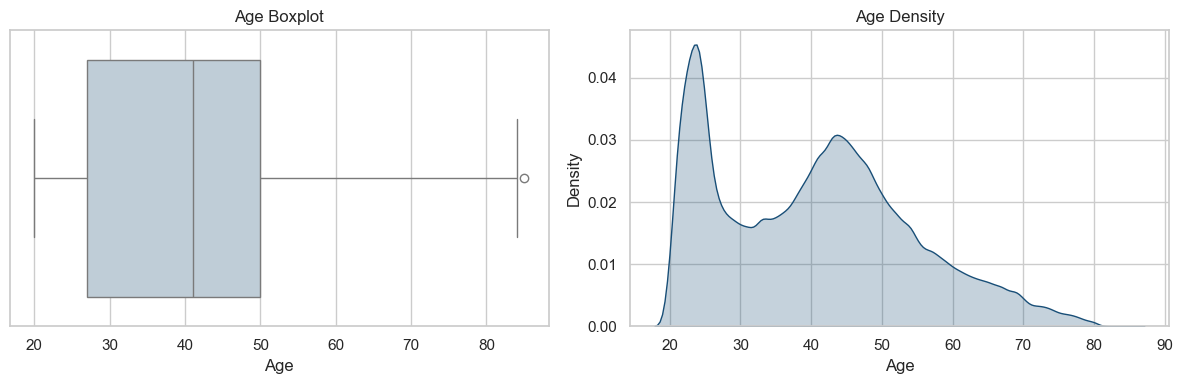

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=train_df["Age"], ax=axes[0], color="#bbcddb")
axes[0].set_title("Age Boxplot")
sns.kdeplot(train_df["Age"], ax=axes[1], fill=True, color="#184e77")
axes[1].set_title("Age Density")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df_downsampled["Age"], ax=axes[0], color="#bbcddb")
axes[0].set_title("Age Boxplot")
sns.kdeplot(df_downsampled["Age"], ax=axes[1], fill=True, color="#184e77")
axes[1].set_title("Age Density")
plt.tight_layout()
plt.show()

Gender Distribution

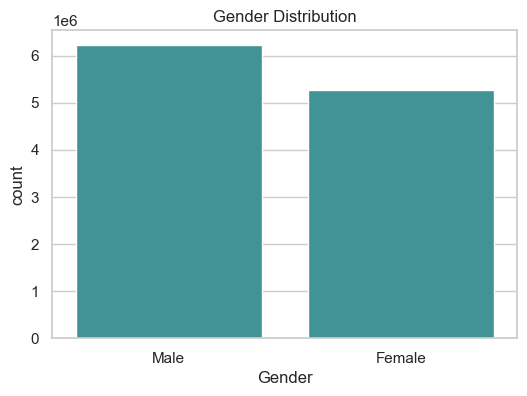

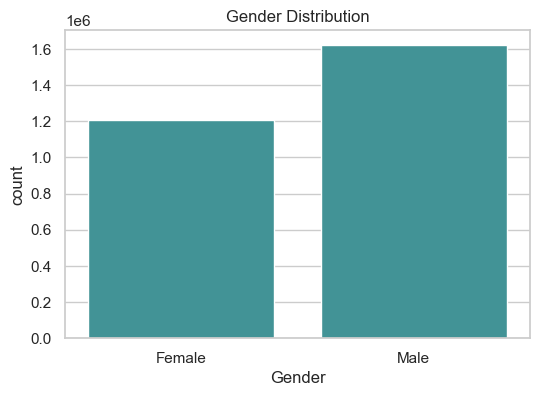

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Gender", data=train_df, color="#34a0a4")
plt.title("Gender Distribution")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x="Gender", data=df_downsampled, color="#34a0a4")
plt.title("Gender Distribution")
plt.show()

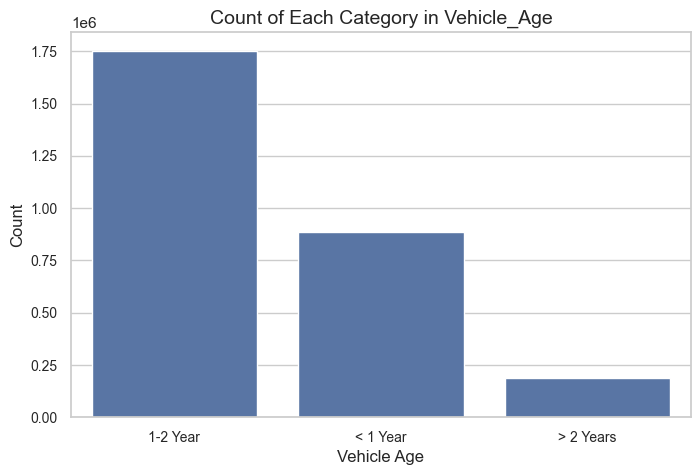

In [12]:
if isinstance(df_downsampled, pd.DataFrame):  
  # Plot the counts of each category in Vehicle_Age  
  plt.figure(figsize=(8, 5))  
  sns.countplot(x="Vehicle_Age", data=df_downsampled, order=df_downsampled["Vehicle_Age"].value_counts().index)  

  # Add labels and title  
  plt.title("Count of Each Category in Vehicle_Age", fontsize=14)  
  plt.xlabel("Vehicle Age", fontsize=12)  
  plt.ylabel("Count", fontsize=12)  
  plt.xticks(fontsize=10)  
  plt.yticks(fontsize=10)  
  plt.show()  
else:  
  print("`df_downsampled` is not defined as a DataFrame. Check your variable assignment.")

Correlation Matrix (Numeric Features)

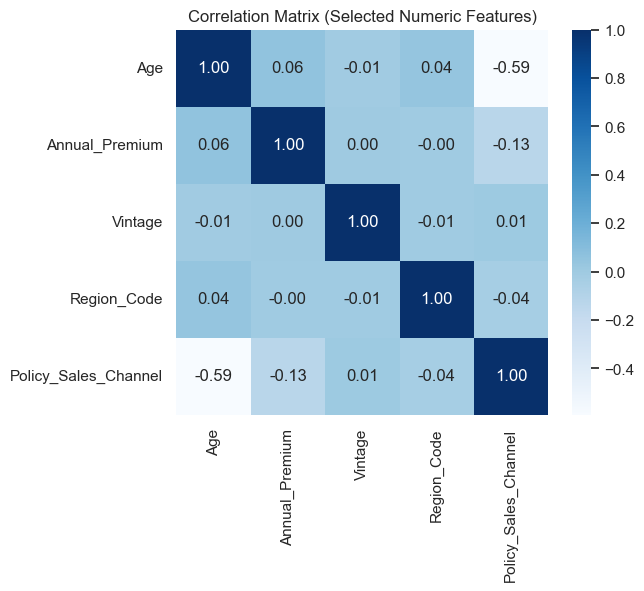

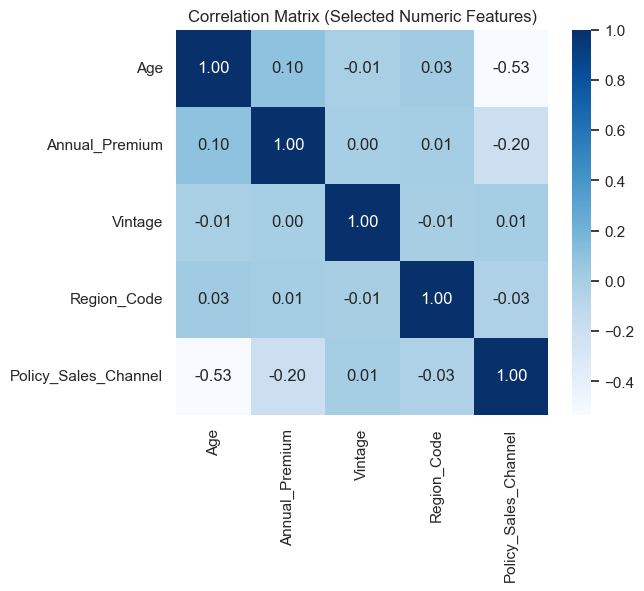

In [13]:
num_cols = ["Age", "Annual_Premium", "Vintage", "Region_Code", "Policy_Sales_Channel"]
corr = train_df[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix (Selected Numeric Features)")
plt.show()

num_cols = ["Age", "Annual_Premium", "Vintage", "Region_Code", "Policy_Sales_Channel"]
corr = df_downsampled[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix (Selected Numeric Features)")
plt.show()


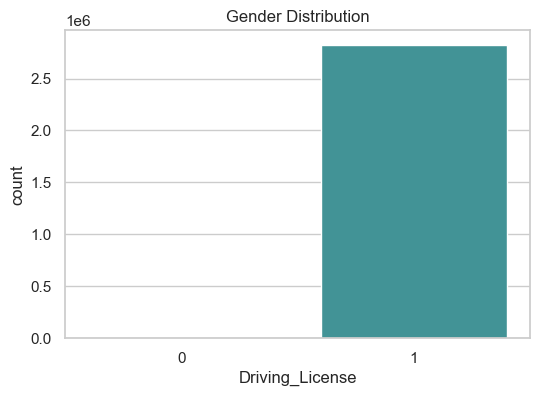

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Driving_License", data=df_downsampled, color="#34a0a4")
plt.title("Gender Distribution")
plt.show()

Driving_License is always True, it does not provide any useful information to the model so can be safely removed without affecting the model's performance.

**5. Data Preparation**


In [15]:
  # Step 2: Drop columns
df_downsampled.drop(["id", "Driving_License"], axis=1, inplace=True)  
test_ids = test_df["id"].copy()  # Save test IDs  
test_df.drop(["id", "Driving_License"], axis=1, inplace=True)  

# Step 3: Map Gender  
df_downsampled["Gender"] = df_downsampled["Gender"].map({"Male": 1, "Female": 0})  
test_df["Gender"] = test_df["Gender"].map({"Male": 1, "Female": 0})  

# Step 4: Map Vehicle_Damage  
df_downsampled["Vehicle_Damage"] = df_downsampled["Vehicle_Damage"].map({"Yes": 1, "No": 0})  
test_df["Vehicle_Damage"] = test_df["Vehicle_Damage"].map({"Yes": 1, "No": 0})  

# Step 5: One-hot encode Vehicle_Age  
df_downsampled = pd.get_dummies(df_downsampled, columns=["Vehicle_Age"], prefix="Vehicle_Age", drop_first=True)  
test_df = pd.get_dummies(test_df, columns=["Vehicle_Age"], prefix="Vehicle_Age", drop_first=True)  

# Verify results  
print("Downsampled DataFrame:")  
print(df_downsampled.head())

Downsampled DataFrame:
   Gender  Age  Region_Code  Previously_Insured  Vehicle_Damage  \
0       0   44         28.0                   0               1   
1       1   60         33.0                   1               0   
2       0   46         28.0                   0               1   
3       0   24         41.0                   1               0   
4       0   38         20.0                   0               1   

   Annual_Premium  Policy_Sales_Channel  Vintage  Response  \
0         56986.0                  26.0       11         1   
1          2630.0                 152.0      275         0   
2         46509.0                 156.0      249         0   
3         28292.0                 152.0      191         0   
4          2630.0                  26.0      272         0   

   Vehicle_Age_< 1 Year  Vehicle_Age_> 2 Years  
0                 False                  False  
1                 False                  False  
2                 False                  False  
3    

Split Features/Target

In [16]:
X = df_downsampled.drop("Response", axis=1)
y = df_downsampled["Response"]  # convert to [0, 1]

print(X.shape, y.shape)

(2830118, 10) (2830118,)



**Model Training (XGBoost)**


Train-Test Split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Hyperparameter Tuning (GridSearchCV)


In [18]:
from sklearn.pipeline import Pipeline  
from sklearn.preprocessing import StandardScaler  


pipeline = Pipeline([  
    ('scaler', StandardScaler()), 
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))  
])  

# Expanded hyperparameter grid  
param_grid = {  
    'xgb__n_estimators': [400, 600, 800],  
    'xgb__max_depth': [6, 8, 10],  
    'xgb__learning_rate': [0.01, 0.05, 0.1],  
    'xgb__subsample': [0.7, 0.8, 0.9],  
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],  
    'xgb__gamma': [0, 0.1, 0.2],  
    'xgb__reg_alpha': [0, 0.01, 0.1],  
    'xgb__reg_lambda': [1, 1.5, 2]  
}

In [19]:
from sklearn.model_selection import StratifiedKFold  

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  


In [ ]:
from time import time  

# Initialize GridSearchCV  
gridsearch = GridSearchCV(  
    estimator=pipeline,  
    param_grid=param_grid,  
    scoring='roc_auc',  
    cv=cv_strategy,  
    verbose=2,  
    n_jobs=-1,  
    return_train_score=True  
)  

# Fit GridSearchCV  
start_time = time()  
gridsearch.fit(X_train, y_train)  
end_time = time()  

print(f"GridSearchCV completed in {(end_time - start_time)/60:.2f} minutes")  
print("Best Parameters:", gridsearch.best_params_)  
print("Best ROC AUC Score:", gridsearch.best_score_)


In [ ]:
best_model = gridsearch.best_estimator_

y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

auc_val = roc_auc_score(y_val, y_val_pred_proba)
print("Validation AUC:", auc_val)

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
plt.plot([0,1],[0,1], linestyle="--", color="r")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

I am unable to execute this code at present due to its lengthy and complex computational requirements. Therefore, I have opted to utilize the Google Colab GPU engine for its execution.


This approach of training our data across four distinct will provide valuable insights into their comparative performance. By analyzing the results, we can identify the model that best meets our objectives. 

**The models:**
1. Logistic Regression : A simple linear model that is highly interpretable and effective for linearly separable data.
2. Neural Network : A deep learning-based, multi-layer perceptron with hidden layers, designed for learning complex relationships in the data.
3. XGBoost : A gradient-boosting model optimized for speed, accuracy, and efficiency, excellent for structured data.
4. LightGBM :A gradient-boosting method like XGBoost but optimized for faster training and lower memory usage.






In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

**Logistic Regression**


Logistic Regression Metrics:
AUC-ROC Score: 0.8409768317958495
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74    353765
           1       0.71      0.97      0.82    353765

    accuracy                           0.79    707530
   macro avg       0.83      0.79      0.78    707530
weighted avg       0.83      0.79      0.78    707530



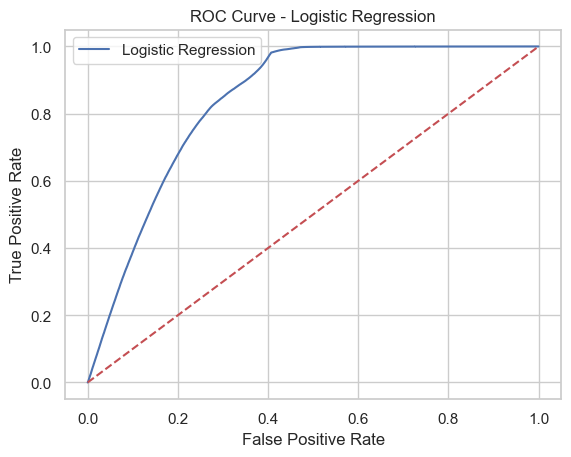

In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict & Evaluate
y_pred_logreg = logreg.predict(X_test_scaled)
y_pred_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression Metrics:")
print(f"AUC-ROC Score: {roc_auc_score(y_val, y_pred_prob_logreg)}")
print("Classification Report:")
print(classification_report(y_val, y_pred_logreg))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_logreg)
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve - Logistic Regression")
plt.show()



**Neural Network**

C:\Users\Ibrahim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
26533/26533 ━━━━━━━━━━━━━━━━━━━━ 21s 757us/step - accuracy: 0.7941 - loss: 0.4313 - val_accuracy: 0.8000 - val_loss: 0.4207
Epoch 2/20
26533/26533 ━━━━━━━━━━━━━━━━━━━━ 21s 786us/step - accuracy: 0.7992 - loss: 0.4222 - val_accuracy: 0.8000 - val_loss: 0.4200
Epoch 3/20
26533/26533 ━━━━━━━━━━━━━━━━━━━━ 21s 803us/step - accuracy: 0.7989 - loss: 0.4221 - val_accuracy: 0.8003 - val_loss: 0.4195
Epoch 4/20
26533/26533 ━━━━━━━━━━━━━━━━━━━━ 22s 827us/step - accuracy: 0.8000 - loss: 0.4207 - val_accuracy: 0.8004 - val_loss: 0.4191
Epoch 5/20
26533/26533 ━━━━━━━━━━━━━━━━━━━━ 20s 735us/step - accuracy: 0.7996 - loss: 0.4212 - val_accuracy: 0.8007 - val_loss: 0.4190
Epoch 6/20
26533/26533 ━━━━━━━━━━━━━━━━━━━━ 20s 757us/step - accuracy: 0.7996 - loss: 0.4213 - val_accuracy: 0.8004 - val_loss: 0.4194
Epoch 7/20
26533/26533 ━━━━━━━━━━━━━━━━━━━━ 20s 749us/step - accuracy: 0.8001 - loss: 0.4208 - val_accuracy: 0.8005 - val_loss: 0.4190
Epoch 8/20
26533/26533 ━━━━━━━━━━━━━━━━━━━━ 20s 750us/s

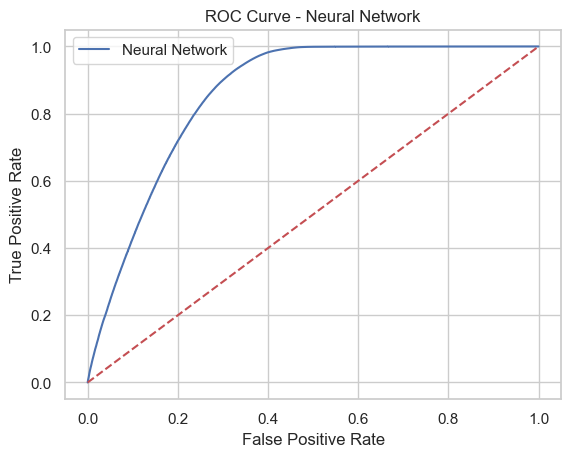

In [23]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.metrics import roc_auc_score, classification_report, roc_curve  
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.callbacks import EarlyStopping  

# Assuming X_train_scaled and y_train are defined, scaled, and ready for training  

# Build a simple neural network  
nn_model = Sequential([  
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),  
    Dropout(0.3),  
    Dense(32, activation='relu'),  
    Dropout(0.2),  
    Dense(1, activation='sigmoid')  # Binary classification  
])  

# Compile the model  
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])  

# Create an EarlyStopping callback  
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor the validation loss  
                               patience=5,        # Stop after 5 epochs of no improvement  
                               verbose=1,        # Print message when stopping  
                               restore_best_weights=True)  # Restore the model weights from the epoch with the best validation loss  

# Train the model with EarlyStopping  
history = nn_model.fit(X_train_scaled,   
                        y_train,   
                        validation_split=0.2,   
                        epochs=20,   
                        batch_size=64,   
                        verbose=1,   
                        callbacks=[early_stopping])  

# Evaluate the model  
nn_pred_prob = nn_model.predict(X_test_scaled).flatten()  
nn_pred = (nn_pred_prob > 0.5).astype(int)  

print("\nNeural Network Metrics:")  
print(f"AUC-ROC Score: {roc_auc_score(y_val, nn_pred_prob)}")  
print("Classification Report:")  
print(classification_report(y_val, nn_pred))  

# Plot ROC Curve  
fpr, tpr, thresholds = roc_curve(y_val, nn_pred_prob)  
plt.plot(fpr, tpr, label="Neural Network")  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlabel("False Positive Rate")  
plt.ylabel("True Positive Rate")  
plt.legend()  
plt.title("ROC Curve - Neural Network")  
plt.show()

**XGBoost**

C:\Users\Ibrahim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:58:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Metrics:
AUC-ROC Score: 0.8773
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.69      0.79    353765
           1       0.75      0.93      0.83    353765

    accuracy                           0.81    707530
   macro avg       0.83      0.81      0.81    707530
weighted avg       0.83      0.81      0.81    707530



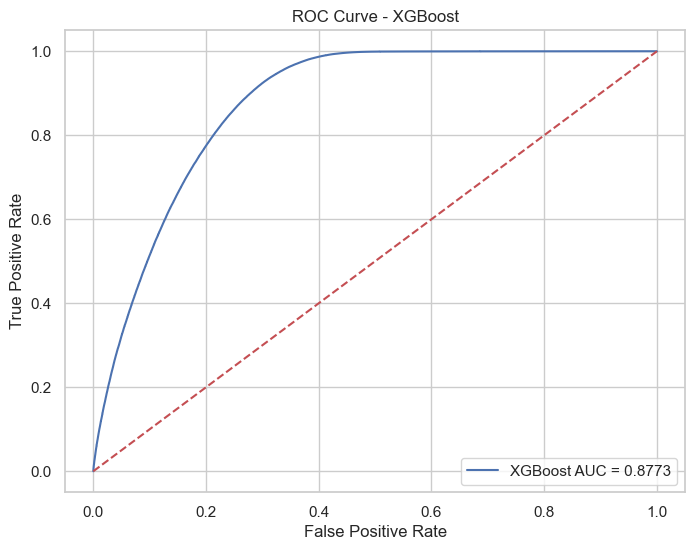

In [24]:
from xgboost import XGBClassifier  
from sklearn.metrics import roc_auc_score, classification_report, roc_curve  
import matplotlib.pyplot as plt  

# Step 1: Clean Feature Names (if `X_train` and `X_val` are Pandas DataFrames)  
# Convert column names to strings and remove invalid characters  
def clean_column_names(df):  
    """Cleans column names to remove or replace invalid characters."""  
    df.columns = [str(col).replace("[", "_").replace("]", "_").replace("<", "").replace(">", "") for col in df.columns]  
    return df  

# Apply this function to X_train and X_val  
X_train = clean_column_names(X_train)  
X_val = clean_column_names(X_val)  

# Step 2: Initialize and Train the Model  
xgb_model = XGBClassifier(  
    n_estimators=500,  # Number of trees  
    max_depth=6,  # Maximum depth of trees  
    learning_rate=0.05,  # Learning rate  
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Balance classes  
    random_state=42,  # Set random seed  
    use_label_encoder=False,  # Suppress deprecation warning  
    eval_metric="logloss",  # Specify evaluation metric  
)  

# Fit the model to the training data  
xgb_model.fit(X_train, y_train)  

# Step 3: Make Predictions  
y_pred_xgb = xgb_model.predict(X_val)  # Class predictions  
y_pred_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class only  

# Step 4: Evaluate the Model  
print("\nXGBoost Metrics:")  
print(f"AUC-ROC Score: {roc_auc_score(y_val, y_pred_prob_xgb):.4f}")  
print("Classification Report:\n", classification_report(y_val, y_pred_xgb))  

# Step 5: Plot the ROC Curve  
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_xgb)  
plt.figure(figsize=(8, 6))  
plt.plot(fpr, tpr, label="XGBoost AUC = {:.4f}".format(roc_auc_score(y_val, y_pred_prob_xgb)))  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlabel("False Positive Rate")  
plt.ylabel("True Positive Rate")  
plt.title("ROC Curve - XGBoost")  
plt.legend(loc="lower right")  
plt.show()

**LightGBM**

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1061294, number of negative: 1061294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 2122588, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM Metrics:
AUC-ROC Score: 0.8775220974289988
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79    353765
  

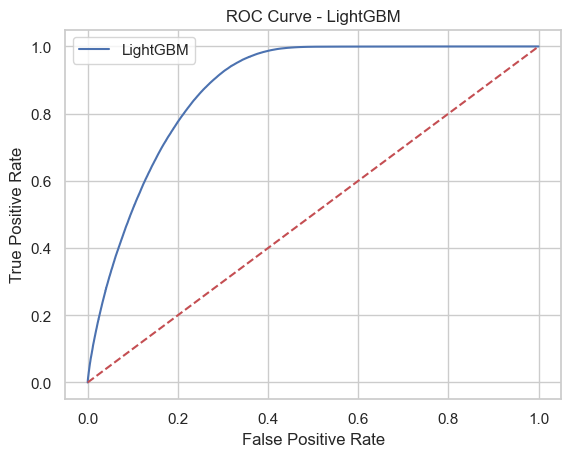

In [26]:
from lightgbm import LGBMClassifier


# Train a LightGBM Classifier
lgb_model = LGBMClassifier(
    n_estimators=500, 
    max_depth=6, 
    learning_rate=0.05, 
    class_weight='balanced', 
    random_state=42
)
lgb_model.fit(X_train, y_train)

# Predict & Evaluate
y_pred_lgb = lgb_model.predict(X_val)
y_pred_prob_lgb = lgb_model.predict_proba(X_val)[:, 1]

print("\nLightGBM Metrics:")
print(f"AUC-ROC Score: {roc_auc_score(y_val, y_pred_prob_lgb)}")
print("Classification Report:")
print(classification_report(y_val, y_pred_lgb))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_lgb)
plt.plot(fpr, tpr, label="LightGBM")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve - LightGBM")
plt.show()


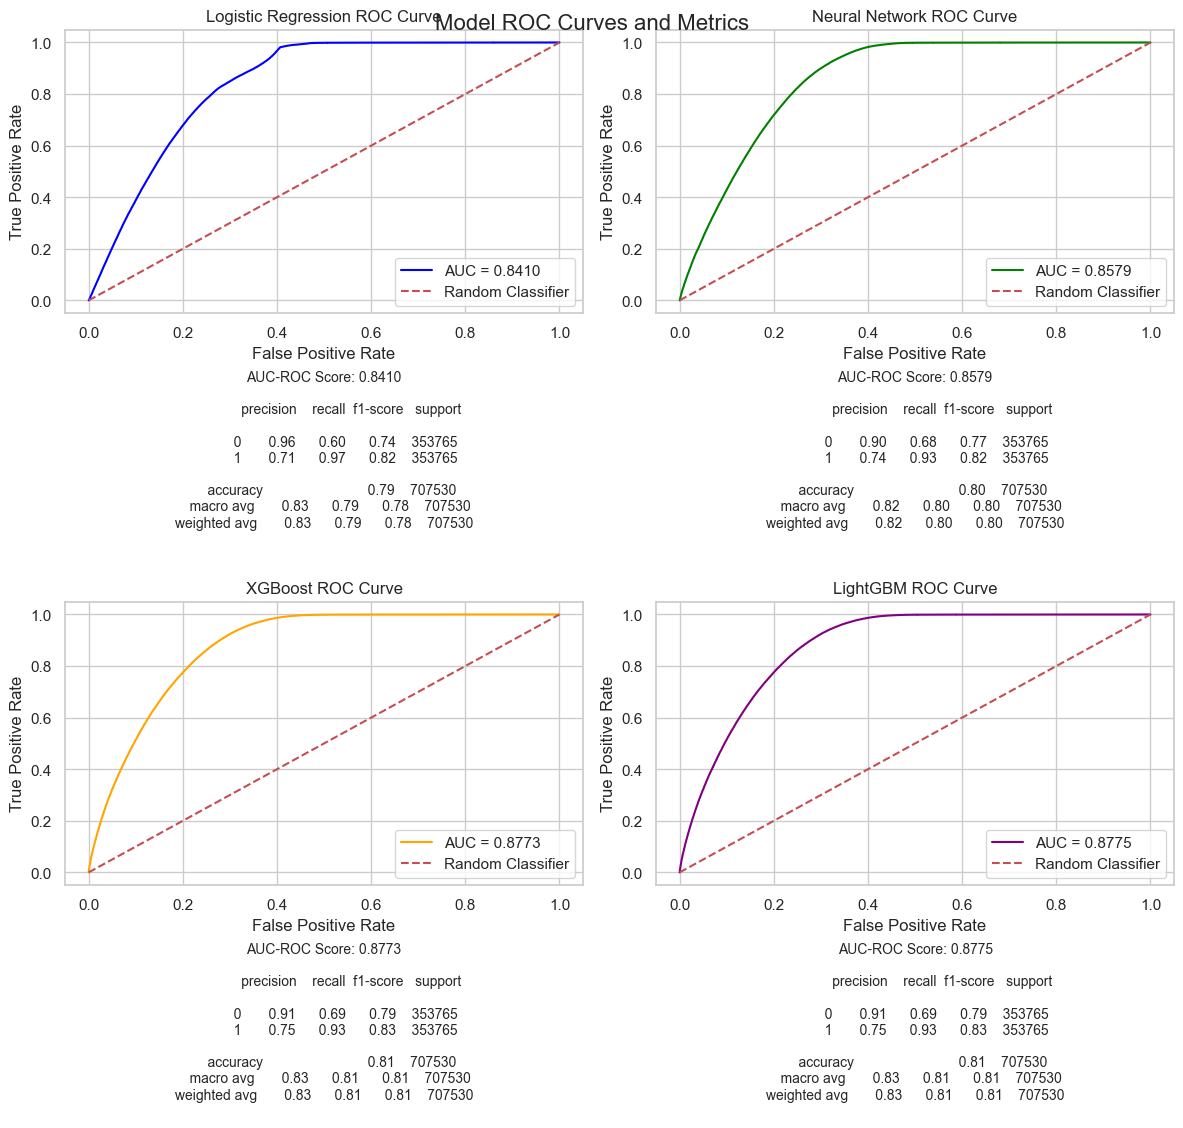

In [28]:
import matplotlib.pyplot as plt  
import numpy as np  
from sklearn.metrics import roc_auc_score, classification_report, roc_curve  

# Logistic Regression  
logreg_auc = roc_auc_score(y_val, y_pred_prob_logreg)
fpr_logreg, tpr_logreg, _ = roc_curve(y_val, y_pred_prob_logreg)  
logreg_report = classification_report(y_val, y_pred_logreg)  

# Neural Network  
nn_auc = roc_auc_score(y_val, nn_pred_prob)
fpr_nn, tpr_nn, _ = roc_curve(y_val,nn_pred_prob)  
nn_report = classification_report(y_val, nn_pred)  

# XGBoost  
xgb_auc = roc_auc_score(y_val, y_pred_prob_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_prob_xgb)  
xgb_report = classification_report(y_val, y_pred_xgb)  

# LightGBM  
lgb_auc = roc_auc_score(y_val, y_pred_prob_lgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, y_pred_prob_lgb)  
lgb_report = classification_report(y_val, y_pred_lgb)  

# Create a figure with subplots  
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # 2 rows, 2 columns for ROC curves  
fig.subplots_adjust(hspace=0.5)  # Adjust spacing between subplots  
fig.suptitle("Model ROC Curves and Metrics", fontsize=16, y=0.95)  # Add overall title  

# Plot ROC curve for Logistic Regression  
axes[0, 0].plot(fpr_logreg, tpr_logreg, label=f"AUC = {logreg_auc:.4f}", color="blue")  
axes[0, 0].plot([0, 1], [0, 1], 'r--', label="Random Classifier")  
axes[0, 0].set_title("Logistic Regression ROC Curve")  
axes[0, 0].set_xlabel("False Positive Rate")  
axes[0, 0].set_ylabel("True Positive Rate")  
axes[0, 0].legend()  
axes[0, 0].text(  
    0.5, -0.2, f"AUC-ROC Score: {logreg_auc:.4f}\n\n{logreg_report}",  
    fontsize=10, ha="center", va="top", transform=axes[0, 0].transAxes  
)  

# Plot ROC curve for Neural Network  
axes[0, 1].plot(fpr_nn, tpr_nn, label=f"AUC = {nn_auc:.4f}", color="green")  
axes[0, 1].plot([0, 1], [0, 1], 'r--', label="Random Classifier")  
axes[0, 1].set_title("Neural Network ROC Curve")  
axes[0, 1].set_xlabel("False Positive Rate")  
axes[0, 1].set_ylabel("True Positive Rate")  
axes[0, 1].legend()  
axes[0, 1].text(  
    0.5, -0.2, f"AUC-ROC Score: {nn_auc:.4f}\n\n{nn_report}",  
    fontsize=10, ha="center", va="top", transform=axes[0, 1].transAxes  
)  

# Plot ROC curve for XGBoost  
axes[1, 0].plot(fpr_xgb, tpr_xgb, label=f"AUC = {xgb_auc:.4f}", color="orange")  
axes[1, 0].plot([0, 1], [0, 1], 'r--', label="Random Classifier")  
axes[1, 0].set_title("XGBoost ROC Curve")  
axes[1, 0].set_xlabel("False Positive Rate")  
axes[1, 0].set_ylabel("True Positive Rate")  
axes[1, 0].legend()  
axes[1, 0].text(  
    0.5, -0.2, f"AUC-ROC Score: {xgb_auc:.4f}\n\n{xgb_report}",  
    fontsize=10, ha="center", va="top", transform=axes[1, 0].transAxes  
)  

# Plot ROC curve for LightGBM  
axes[1, 1].plot(fpr_lgb, tpr_lgb, label=f"AUC = {lgb_auc:.4f}", color="purple")  
axes[1, 1].plot([0, 1], [0, 1], 'r--', label="Random Classifier")  
axes[1, 1].set_title("LightGBM ROC Curve")  
axes[1, 1].set_xlabel("False Positive Rate")  
axes[1, 1].set_ylabel("True Positive Rate")  
axes[1, 1].legend()  
axes[1, 1].text(  
    0.5, -0.2, f"AUC-ROC Score: {lgb_auc:.4f}\n\n{lgb_report}",  
    fontsize=10, ha="center", va="top", transform=axes[1, 1].transAxes  
)  

plt.tight_layout()  
plt.show()

**1. Logistic Regression**
- **Performance:**
  - **AUC-ROC Score:** 0.8410.
  - **Accuracy:** 0.79.
  - Relatively strong **recall** for class 1 (97%) but lower for class 0 (60%). 
  - While the model performs well for a simple algorithm, it falls behind more sophisticated models like XGBoost and LightGBM.

**2. Neural Network**
- **Performance:**
  - **AUC-ROC Score:** 0.8577.
  - **Accuracy:** 0.80.
  - Improved recall compared to Logistic Regression (93% for class 1, 67% for class 0) with better overall balance between precision and recall.
  - It outperformed Logistic Regression but required more computational resources.


**3. XGBoost**
- **Performance:**
  - **AUC-ROC Score:** 0.8773.
  - **Accuracy:** 0.81.
  - Demonstrated high **recall** for class 1 (93%), with an overall robust classification performance.
  - Slightly better precision-recall tradeoff compared to Neural Networks.

**4. LightGBM**
- **Performance:**
  - **AUC-ROC Score:** 0.8775 (highest among all models but tied with XGBoost).
  - **Accuracy:** 0.81.
  - Near-identical performance to XGBoost in terms of metrics, with minor differences due to model-specific optimizations.
  - Similarly recalls 93% of positive cases, making it equally suitable for this task.

**Overall Insights and Recommendations:**
1. **Top Performers:** Both **XGBoost** and **LightGBM** emerged as the best-performing models, achieving the highest AUC-ROC scores (0.8773 and 0.8775) and accuracy (81%). They are well-suited for tasks requiring high precision and recall.
2. **Neural Network:** While slightly less accurate than the boosting models, the Neural Network provided a competitive AUC-ROC score (0.8577) and remains a strong alternative for non-linear and feature-rich datasets.
3. **Logistic Regression:** Although simpler and less computationally intensive, Logistic Regression underperformed compared to other models. It is better suited for interpretable, linearly-separable problems or as a baseline model.


**Recommendation:**
For this specific classification task:
- **XGBoost** and **LightGBM** are recommended due to their superior performance and ability to handle complex feature interactions.
- If computational resources are limited, **Logistic Regression** can provide a fast, interpretable solution, albeit with lower performance.
- **Neural Network** is a viable option for more complex datasets that require flexibility in feature representation. 


